# LDA model on orthopedic surgery

- dropped top 15 cols
- dropped cols with < 4 claims
- dropped npi 1376541979
- dropped npi's with < 10 claims
- number of topics = 10
- bene_unique_cnt as value

In [129]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import time
import re

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [4]:
q = """SELECT npi,
        hcpcs_code, 
        hcpcs_description, 
        bene_unique_cnt,
        nppes_provider_last_org_name, 
        nppes_provider_first_name, 
        nppes_provider_state
FROM payments 
WHERE provider_type='Orthopedic Surgery'"""
payments = pd.read_sql_query(q, con=con)

In [5]:
payments.shape

(312006, 7)

## Read in data matrix generated in ipynb 17

In [19]:
## read in reduced data set
by_npi = pd.read_csv("17_by_npi_reduced_ortho.csv", index_col=0)
by_npi.index = by_npi.index.astype(str)
by_npi.shape

(11242, 795)

## LDA on filtered data frame using 10 topics

In [21]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [22]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [23]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=10, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 178.75277709960938s


In [24]:
## Save model
ldamodel.save("18_lda_10topics_ortho.model", pickle_protocol=3)

## Interpret the 10 topics in the model

In [287]:
## top 30 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=30)

In [288]:
## for each topic, store indices of top 30 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [289]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [290]:
## some words / hcpcs_codes are appended with '_O' or '_F'.
## remove these suffixes so we can map them back to the hcpcs descriptions

def remove_suffix(s):
    code = re.search(r'([a-zA-Z0-9]+)(_O)*(_F)*', s)
    if code.group(2) is not None:
        return code.group(1), 'O'
    elif code.group(3) is not None:
        return code.group(1), 'F'
    else:
        return code.group(1), None

In [291]:
topic_dict_nosuffix = {}
place_of_service_cnt = {}

for t, hcpcs_list in topic_dict.items():
    t_list = []
    O_cnt = 0
    F_cnt = 0
    for i in hcpcs_list:
        code, facility = remove_suffix(i)
        t_list.append(code)
        if facility == 'O':
            O_cnt += 1
        elif facility == 'F':
            F_cnt += 1        

    topic_dict_nosuffix[t] = t_list
    place_of_service_cnt[t] = [O_cnt, F_cnt]

In [292]:
pd.DataFrame([v for k,v in place_of_service_cnt.items()]).rename(columns={0:'out_of_facility_cnt', 1:'in_facility_cnt'})

,out_of_facility_cnt,in_facility_cnt
0,16,8
1,18,5
2,12,2
3,7,2
4,20,2
5,20,4
6,17,3
7,0,27
8,16,0
9,20,0


In [293]:
for t in range(len(place_of_service_cnt)):
    print(t, ': ', place_of_service_cnt[t])

0 :  [16, 8]
1 :  [18, 5]
2 :  [12, 2]
3 :  [7, 2]
4 :  [20, 2]
5 :  [20, 4]
6 :  [17, 3]
7 :  [0, 27]
8 :  [16, 0]
9 :  [20, 0]


### Most of the topics consist of top codes that take place out of facility, except for topic 7.

In [294]:
pd.set_option('max_colwidth',100)
## Topic 0 - spine, lower back
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
79,99215,"Established patient office or other outpatient, visit typically 40 minutes"
129,72100,"X-ray of lower and sacral spine, 2 or 3 views"
276,22214,Incision of spine to correct deformity at lower spinal column
303,72040,"X-ray of spine of neck, 2 or 3 views"
324,72148,MRI scan of lower spinal canal
833,72110,"X-ray of lower and sacral spine, minimum of 4 views"
933,99205,"New patient office or other outpatient visit, typically 60 minutes"
1200,22310,Closed treatment of broken spine bones with casting or bracing
1249,G0434,"Drug screen, other than chromatographic; any number of drug classes, by clia waived test or mode..."


In [295]:
## Topic 1 - lower leg/foot, ankle
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
24,73610,"X-ray of ankle, minimum of 3 views"
25,99212,"Established patient office or other outpatient visit, typically 10 minutes"
27,99222,"Initial hospital inpatient care, typically 50 minutes per day"
28,99223,"Initial hospital inpatient care, typically 70 minutes per day"
44,J1030,"Injection, methylprednisolone acetate, 40 mg"
49,76942,Ultrasonic guidance imaging supervision and interpretation for insertion of needle
72,73600,"X-ray of ankle, 2 views"
73,73630,"X-ray of foot, minimum of 3 views"


In [296]:
## Topic 2 - spine bones
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
25,99212,"Established patient office or other outpatient visit, typically 10 minutes"
79,99215,"Established patient office or other outpatient, visit typically 40 minutes"
129,72100,"X-ray of lower and sacral spine, 2 or 3 views"
248,22851,Insertion of spinal instrumentation for spinal stabilization
249,63047,Partial removal of middle spine bone with release of spinal cord and/or nerves
250,63048,Partial removal of spine bone with release of spinal cord and/or nerves
278,22612,"Fusion of lower spine bones, posterior or posterolateral approach"
279,22614,"Fusion of spine bones, posterior or posterolateral approach"
280,22842,"Insertion of posterior spinal instrumentation for spinal stabilization, 3 to 6 vertebral segments"


In [297]:
## Topic 3 - ER visits, general trauma, more random
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
594,99283,"Emergency department visit, moderately severe problem"
595,J1100,"Injection, dexamethasone sodium phosphate, 1mg"
719,29085,Application of cast to hand and lower forearm
820,99211,"Established patient office or other outpatient visit, typically 5 minutes"
1161,36415,Insertion of needle into vein for collection of blood sample
1180,80048,"Blood test, basic group of blood chemicals"
1181,85025,"Complete blood cell count (red cells, white blood cell, platelets), automated test"
1535,29125,"Application of non-moveable, short arm splint (forearm to hand)"
1997,95886,Needle measurement and recording of electrical activity of muscles of arm or leg complete study
1998,95910,"Nerve transmission studies, 7-8 studies"


In [298]:
## Topic 4 - upper leg: knee, pelvis, hip
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,73510,"X-ray of ribs of one side of body, minimum of 2 views"
3,73562,"X-ray of knee, 3 views"
4,73564,"X-ray of knee, 4 or more views"
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
10,27447,Repair of knee joint
19,72170,"X-ray of pelvis, 1 or 2 views"
20,73500,"X-ray of hip on one side of body, 1 view"
23,73560,"X-ray of knee, 1 or 2 views"
24,73610,"X-ray of ankle, minimum of 3 views"


In [299]:
## Topic 5 - arthritis/carpal tunnel/hand, wrist, fingers
## in office joint pain meds - triamcinolone acetonide, methylprednisolone, betamethasone acetate
t = 5
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
25,99212,"Established patient office or other outpatient visit, typically 10 minutes"
44,J1030,"Injection, methylprednisolone acetate, 40 mg"
81,J0702,"Injection, betamethasone acetate 3mg and betamethasone sodium phosphate 3mg"
96,73100,"X-ray of wrist, 2 views"
114,99202,"New patient office or other outpatient visit, typically 20 minutes"
126,20605,Aspiration and/or injection of medium joint or joint capsule
133,73110,"X-ray of wrist, minimum of 3 views"
134,73140,"X-ray of fingers, minimum of 2 views"


In [300]:
## Topic 6 - knee and shoulder
t = 6
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,73510,"X-ray of ribs of one side of body, minimum of 2 views"
3,73562,"X-ray of knee, 3 views"
4,73564,"X-ray of knee, 4 or more views"
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
19,72170,"X-ray of pelvis, 1 or 2 views"
23,73560,"X-ray of knee, 1 or 2 views"
25,99212,"Established patient office or other outpatient visit, typically 10 minutes"
44,J1030,"Injection, methylprednisolone acetate, 40 mg"
49,76942,Ultrasonic guidance imaging supervision and interpretation for insertion of needle


In [301]:
## Topic 7 - Hospital
t = 7
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
0,20610,Aspiration and/or injection of large joint or joint capsule
1,73030,"X-ray of shoulder, minimum of 2 views"
2,73510,"X-ray of ribs of one side of body, minimum of 2 views"
3,73562,"X-ray of knee, 3 views"
4,73564,"X-ray of knee, 4 or more views"
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
6,99213,"Established patient office or other outpatient visit, typically 15 minutes"
7,99214,"Established patient office or other outpatient, visit typically 25 minutes"
10,27447,Repair of knee joint
19,72170,"X-ray of pelvis, 1 or 2 views"


In [302]:
## Topic 8 - therapy
t = 8
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,73510,"X-ray of ribs of one side of body, minimum of 2 views"
3,73562,"X-ray of knee, 3 views"
4,73564,"X-ray of knee, 4 or more views"
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
19,72170,"X-ray of pelvis, 1 or 2 views"
23,73560,"X-ray of knee, 1 or 2 views"
25,99212,"Established patient office or other outpatient visit, typically 10 minutes"
44,J1030,"Injection, methylprednisolone acetate, 40 mg"
49,76942,Ultrasonic guidance imaging supervision and interpretation for insertion of needle


In [303]:
## Topic 9 - hospital, xray
t = 9
(payments.loc[payments.hcpcs_code.isin(topic_dict_nosuffix[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,73510,"X-ray of ribs of one side of body, minimum of 2 views"
3,73562,"X-ray of knee, 3 views"
4,73564,"X-ray of knee, 4 or more views"
5,99204,"New patient office or other outpatient visit, typically 45 minutes"
8,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"
17,27236,Open treatment of broken thigh bone with insertion of hardware or prosthetic replacement
18,27245,Surgical treatment of broken thigh bone
19,72170,"X-ray of pelvis, 1 or 2 views"
20,73500,"X-ray of hip on one side of body, 1 view"
22,73550,"X-ray of thigh, 2 views"


## Plot distribution of providers per topic

In [61]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

In [69]:
topic_per_doc_df = pd.DataFrame(topic_per_doc).rename(columns={0:'topic'})
topic_per_doc_df.index = by_npi.index

In [73]:
topic_per_doc_df.head()

,topic
1003010919,9
1003017682,4
1003018086,9
1003023276,4
1003024894,4


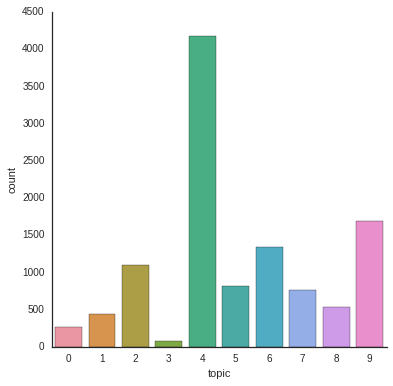

In [71]:
## distribution of providers among topics
ax = sns.countplot(x='topic', data=topic_per_doc_df)
sns.despine()

In [96]:
counts_per_topic = topic_per_doc_df['topic'].value_counts().sort_index()

<Container object of 10 artists>

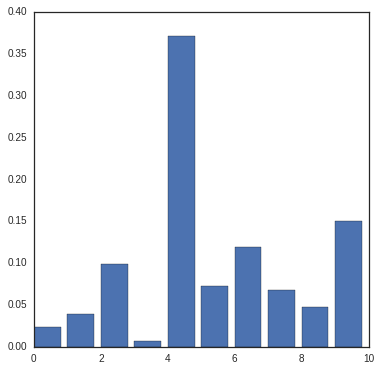

In [97]:
## distribution of providers among topics as fraction
plt.bar(range(10), counts_per_topic/float(len(topic_per_doc_df['topic'])))

## Plot doctors in topic space

In [37]:
from sklearn.manifold import TSNE
#from sklearn import preprocessing

In [38]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(11242, 10)

In [320]:
X_embedded_topics = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi_topics.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11242
[t-SNE] Computed conditional probabilities for sample 2000 / 11242
[t-SNE] Computed conditional probabilities for sample 3000 / 11242
[t-SNE] Computed conditional probabilities for sample 4000 / 11242
[t-SNE] Computed conditional probabilities for sample 5000 / 11242
[t-SNE] Computed conditional probabilities for sample 6000 / 11242
[t-SNE] Computed conditional probabilities for sample 7000 / 11242
[t-SNE] Computed conditional probabilities for sample 8000 / 11242
[t-SNE] Computed conditional probabilities for sample 9000 / 11242
[t-SNE] Computed conditional probabilities for sample 10000 / 11242
[t-SNE] Computed conditional probabilities for sample 11000 / 11242
[t-SNE] Computed conditional probabilities for sample 11242 / 11242
[t-SNE] Mean sigma: 0.000959
[t-SNE] Iteration 25: error = 1.2036974, gradient norm = 0.0033514
[t-SNE] Iterat

(-15.0, 15.0, -15.0, 15.0)

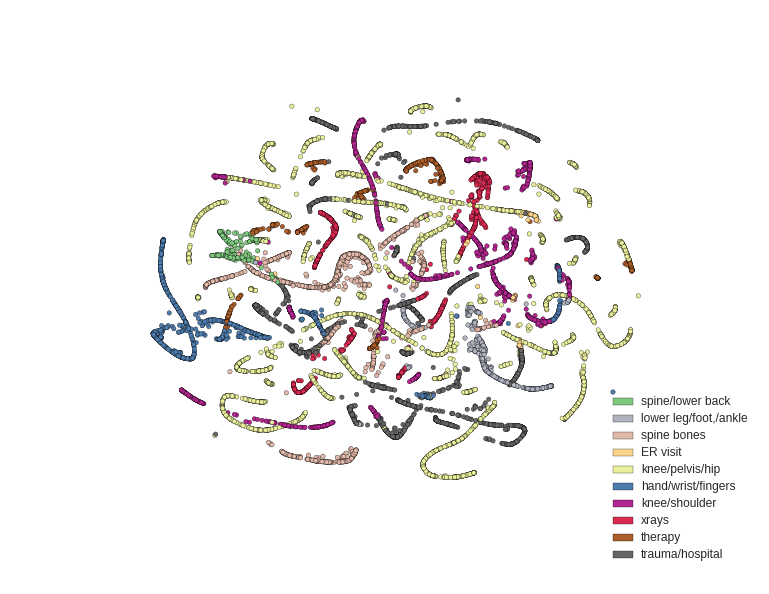

In [331]:
plt.rcParams['figure.figsize']=(13,10)

plt.scatter(X_embedded_topics[:,0], X_embedded_topics[:,1], 
            c=entropy_df['topic'], cmap=plt.get_cmap('Accent', 10))

topics = ['spine/lower back','lower leg/foot,/ankle', 'spine bones', 'ER visit', 'knee/pelvis/hip',
         'hand/wrist/fingers','knee/shoulder','xrays', 'therapy','trauma/hospital']
recs = []
for i in range(0, 10):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=plt.cm.Accent(np.linspace(0, 1, 10))[i]))
plt.legend(recs, topics, loc=4)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')
plt.axis('off')

## quantify sharpness of probability distribution over topics per doctor

In [345]:
by_npi_topics.index = by_npi.index.astype(str)
by_npi_topics.head()

,0,1,2,3,4,5,6,7,8,9
1003010919,0.026377,0.026379,0.026378,0.026376,0.026384,0.026377,0.026379,0.026377,0.026378,0.762595
1003017682,0.022912,0.022920,0.022912,0.022910,0.793732,0.022919,0.022922,0.022911,0.022915,0.022946
1003018086,0.023833,0.023835,0.023834,0.023833,0.023843,0.023836,0.023852,0.023834,0.023837,0.785462
1003023276,0.021214,0.021231,0.021215,0.021214,0.809021,0.021229,0.021224,0.021215,0.021216,0.021220
1003024894,0.027813,0.027815,0.027812,0.027811,0.749655,0.027818,0.027815,0.027833,0.027813,0.027816


In [49]:
entropy_per_npi = by_npi_topics.apply(np.log, axis=1).mul(by_npi_topics).sum(axis=1).multiply(-1)

In [50]:
len(entropy_per_npi)

11242

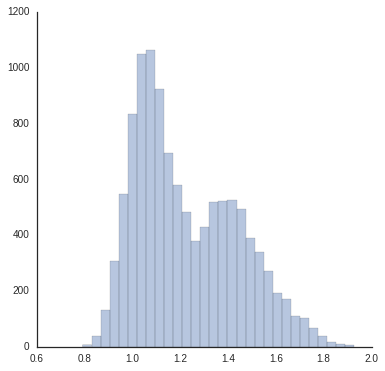

In [51]:
plt.rcParams['figure.figsize']=(6,6)
g = sns.distplot(entropy_per_npi, kde=False, bins=30)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()   

In [52]:
##  maximum entropy over 10 topics = -10 * (1/10)log(1/10)
-1*np.log(1/10)

2.3025850929940455

In [130]:
entropy_df = pd.DataFrame(entropy_per_npi).rename(columns={0:'entropy'})
entropy_df.index = by_npi.index
entropy_df = (entropy_df.merge(payments.drop_duplicates('npi')[['npi',
                                            'nppes_provider_last_org_name',
                                            'nppes_provider_first_name',
                                            'nppes_provider_state']], 
                               right_on='npi', left_index=True).
              merge(topic_per_doc_df, left_on='npi', right_index=True))
entropy_df.head()

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
17,1.069702,1003010919,FREDERICKS,PETER,CO,9
62,0.962187,1003017682,AKHTAR,NAUMAN,VA,4
92,0.991296,1003018086,QUESADA,MARIO,TX,9
119,0.907265,1003023276,JARRELL,SHELBY,NM,4
150,1.112778,1003024894,NECCI,MICHAEL,OH,4


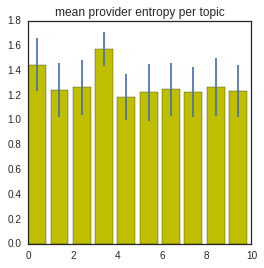

In [138]:
## average entropy of providers per topic
mean_entropy_per_topic = entropy_df.groupby('topic')['entropy'].mean()
std_entropy_per_topic = entropy_df.groupby('topic')['entropy'].std()
ax = plt.bar(range(len(mean_entropy_per_topic)), mean_entropy_per_topic, yerr=std_entropy_per_topic, color='y')
plt.title('mean provider entropy per topic')

In [131]:
## Look at the lower entropy providers
low_entropy_providers = entropy_df.query('entropy < 1.0')
low_entropy_providers.head(20)

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
62,0.962187,1003017682,AKHTAR,NAUMAN,VA,4
92,0.991296,1003018086,QUESADA,MARIO,TX,9
119,0.907265,1003023276,JARRELL,SHELBY,NM,4
166,0.992502,1003029034,BOWEN,JOSEPH,ID,4
401,0.972754,1003802646,PERCIVAL,HERBERT,CA,4
438,0.932159,1003805128,ORTIZ,GERALD,NY,4
625,0.963216,1003811514,EARLE,MICHAEL,TX,9
1128,0.962070,1003836164,HEETDERKS,DAVID,MT,4
1624,0.915962,1003869371,BRAZINSKI,MARK,NC,4
1728,0.950129,1003875717,HENSARLING,JEFFREY,SC,4


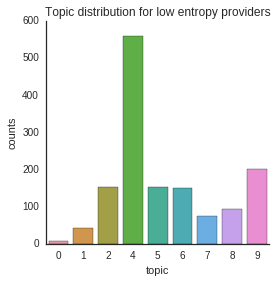

In [132]:
plt.rcParams['figure.figsize']=(4,4)
g = sns.countplot(x = 'topic', data=low_entropy_providers)
g.set(xlabel='topic', ylabel='counts', title='Topic distribution for low entropy providers')
sns.despine()

In [107]:
low_entropy_providers.query('topic == 0').head(5)

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
54249,0.817226,1174516629,PARKER,JEFFREY,MO,0
309275,0.906529,1992708127,FUCHS,PAUL,FL,0
197814,0.922469,1639221948,BURNHAM JR.,WALTER,CA,0
226147,0.937332,1720175714,KESSLER,CHAD,GA,0
53147,0.976523,1164543203,PEERY,DERECK,OK,0


In [106]:
low_entropy_providers.query('topic == 1').head(5)

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
278834,0.883471,1891783387,BOHAY,DONALD,MI,1
222038,0.890160,1710925185,AUBUCHON,CRAIG,MO,1
205084,0.895797,1669422077,MASKILL,JOHN,MI,1
75695,0.899657,1235331570,KLEIBER,BRIAN,MO,1
55961,0.901807,1174593479,SAMMARCO,VINCENT,OH,1


In [146]:
entropy_df_claimcnt = (entropy_df.merge(pd.DataFrame((by_npi > 0).sum(axis = 1)), 
                                        left_on='npi', right_index=True).
                       rename(columns={0:'num_claims'}))

In [147]:
entropy_df_claimcnt.head()

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic,num_claims
17,1.069702,1003010919,FREDERICKS,PETER,CO,9,11
62,0.962187,1003017682,AKHTAR,NAUMAN,VA,4,17
92,0.991296,1003018086,QUESADA,MARIO,TX,9,13
119,0.907265,1003023276,JARRELL,SHELBY,NM,4,20
150,1.112778,1003024894,NECCI,MICHAEL,OH,4,11


In [ ]:
fig = plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize']=(10,10)
ax = sns.lmplot(x="num_claims", y="entropy", hue='topic', data=entropy_df_claimcnt, fit_reg=False)
ax.set(xlabel='number of distinct claims by a doctor', ylabel='entropy')
sns.despine()
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(8)

[None, None, None, None, None, None, None, None, None, None]

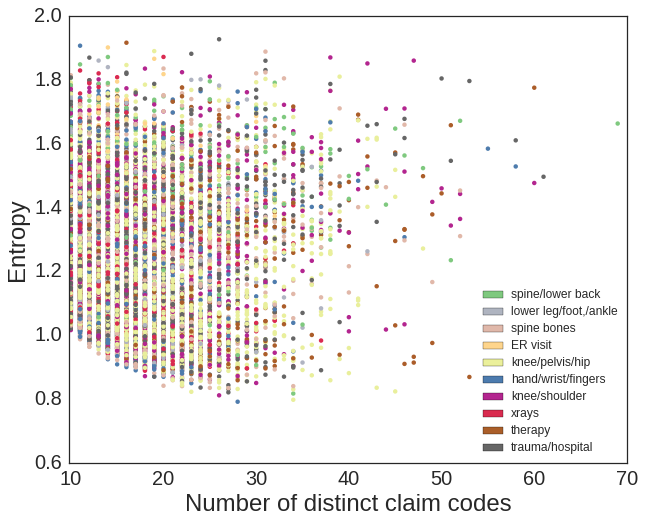

In [317]:
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams.update({'font.size': 200})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

topics = ['spine/lower back','lower leg/foot,/ankle', 'spine bones', 'ER visit', 'knee/pelvis/hip',
         'hand/wrist/fingers','knee/shoulder','xrays', 'therapy','trauma/hospital']

plt.scatter(entropy_df_claimcnt['num_claims'], entropy_df_claimcnt['entropy'], 
            c=entropy_df['topic'], cmap=plt.get_cmap('Accent', 10), linewidth='0')

recs = []
for i in range(0, 10):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=plt.cm.Accent(np.linspace(0, 1, 10))[i]))
plt.legend(recs, topics, loc=4)

plt.xlim(9.8, 70)
plt.xlabel('Number of distinct claim codes', fontsize=24)
plt.ylabel('Entropy', fontsize=24)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')

## Plot t-SNE in original space colored by topic

In [199]:
X_embedded = pd.read_csv("17_X_embedded.csv")

In [201]:
X_embedded.head(2)

,npi,x_tsne,y_tsne
0,1003010919,-1.421955,-4.216352
1,1003017682,-4.383871,-1.350128


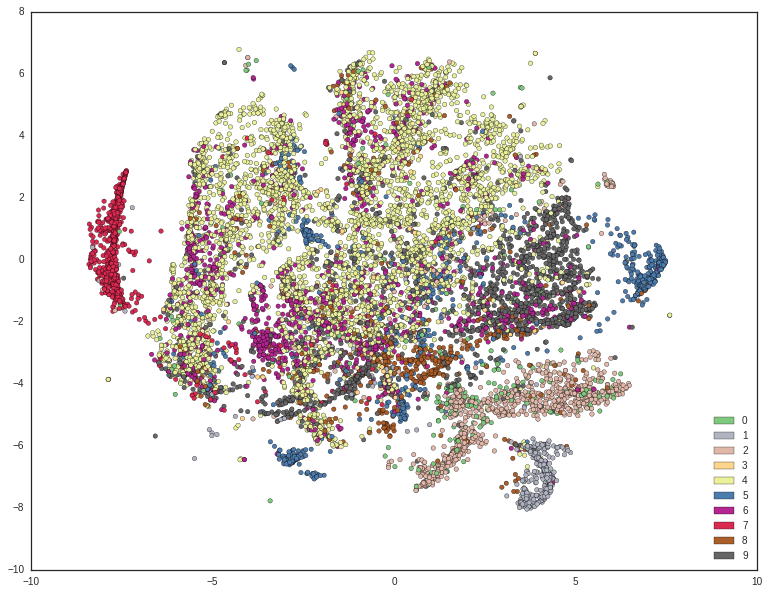

In [225]:
#import matplotlib.patches as mpatches
plt.rcParams['figure.figsize']=(13,10)
plt.scatter(X_embedded['x_tsne'], X_embedded['y_tsne'], 
            c=entropy_df['topic'], cmap=plt.get_cmap('Accent', 10))

recs = []
for i in range(0, 10):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=plt.cm.Accent(np.linspace(0, 1, 10))[i]))
plt.legend(recs, range(10), loc=4)

(-10.0, 10.0, -10.0, 8.0)

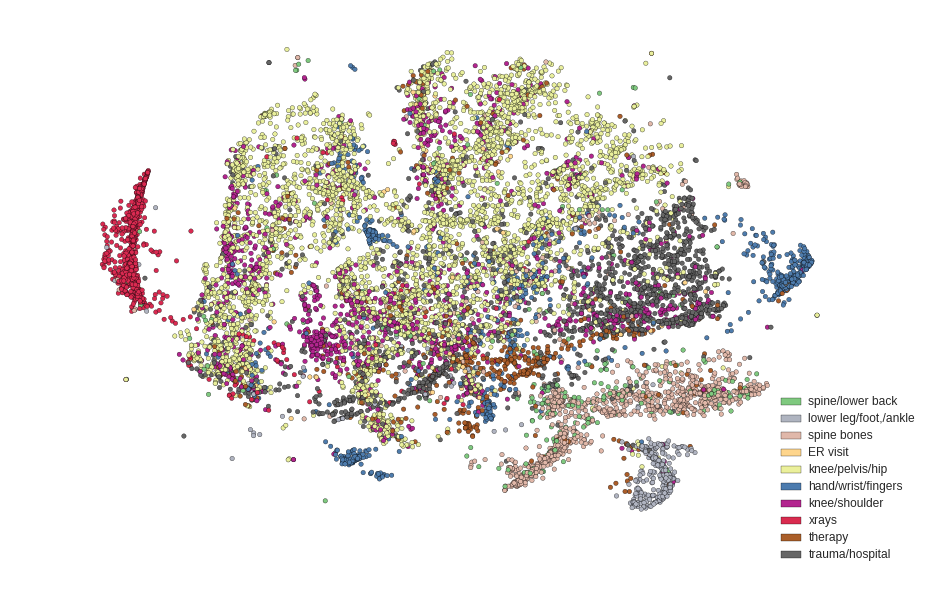

In [318]:
## re-plot with interpretations of topics in legend
plt.rcParams['figure.figsize']=(16,10)
plt.rcParams.update({'font.size': 200})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

topics = ['spine/lower back','lower leg/foot,/ankle', 'spine bones', 'ER visit', 'knee/pelvis/hip',
         'hand/wrist/fingers','knee/shoulder','xrays', 'therapy','trauma/hospital']

plt.scatter(X_embedded['x_tsne'], X_embedded['y_tsne'], 
            c=entropy_df['topic'], cmap=plt.get_cmap('Accent', 10))

recs = []
for i in range(0, 10):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=plt.cm.Accent(np.linspace(0, 1, 10))[i]))
plt.legend(recs, topics, loc=4)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')
plt.axis('off')

## For each topic, get the doctor with the lowest entropy score

In [230]:
entropy_df_claimcnt.loc[entropy_df_claimcnt.groupby('topic')['entropy'].idxmin()]

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic,num_claims
54249,0.817226,1174516629,PARKER,JEFFREY,MO,0,34
278834,0.883471,1891783387,BOHAY,DONALD,MI,1,21
251744,0.834260,1811059470,HANNIBAL,MATTHEW,NC,2,27
73172,1.320111,1235113234,MUNJAL,SANDEEP,IA,3,24
166153,0.797691,1538131412,HANCOCK,CHARLES,GA,4,34
245885,0.791536,1790737492,BLANK,JOHN,VA,5,28
163557,0.811598,1528054269,RUSSELL,MARK,MI,6,26
51686,0.886283,1164433561,PRATT,JEFFREY,WA,7,24
239620,0.858862,1770526410,KILGORE,JOHN,FL,8,28
58498,0.820928,1184678823,GARAPATI,RAJEEV,IL,9,27


- Jeffrey Parker is not listed as a spinal specialist on vitals (http://www.vitals.com/doctors/Dr_Jeffrey_W_Parker.html) but usnews does show him performing a high volume of spinal procedures (http://health.usnews.com/doctors/jeffrey-parker-173337).
- Donald Bohay is confirmed as "specializes in foot and ankle reconstruction, trauma and deformity, including bunions, hammertoes, painful flat feet, arthritis, diabetic foot, sports injuries and complex deformity" http://www.oamichigan.com/staff/donald-bohay-md-facs/
- Matthew Hannibal: "is a Board Certified, Fellowship Trained Orthopedic Spine surgeon and Fellow of the American Academy of Orthopedic Surgeons. He specializes in diagnosing surgically treatable disorders of the neck and back, and using minimally invasive surgical solutions and new spinal technologies to treat them when appropriate." from http://www.carolinaortho.com/offices/boone-office/11-medical-staff/physicians/32-matthew-d-hannibal-md.html
- Sandeep Munjal: confirmed specializes in hip and knee replacement surgery, with special interests in Total Joint Replacement, Hip Resurfacing, Partial Knee Replacement, Computer Assisted Joint Replacement, Robotic Surgery http://www.pcofiowa.com/physician-directory/sandeep-munjal-md/.  Doesn't obviously fit in with "ER" category.
- Charles Hancock: According to http://www.vitals.com/doctors/Dr_Charles_Hancock/profile, specializes in hip and knee osteoarthritis and replacement (athroplasty), carpal tunnel.
- John Blank: According to http://www.tuckahoeortho.com/physicians/john-e-blank-md/, "specializes in surgery of the elbow, wrist and hand."  usnews also mentions carpal tunnel surgery and fellowship in hand surgery.
- Mark Russell (DO): According to https://www.bronsonhealth.com/doctors/markrussell/,  Orthopedic - Hip Replacement, Orthopedic - Joint Replacement, Orthopedic - Knee Replacement, Orthopedic - Shoulder Replacement, Orthopedic - Sports Medicine, Orthopedic - Surgery, Orthopedics & Sports Medicine, Surgery - Orthopedic
- Jeffrey Pratt: Specializes in hand surgery http://doctors.healthgrove.com/l/90979/Jeffrey-Pratt-in-Wenatchee-Washington.  According to https://amwell.com/cm/finder/doctor-detail/jeffrey-pratt-md-wenatchee-washington-1100754/, "specializes in minimally invasive arthroscopic procedures involving the hand, wrist, elbow and shoulder he is also trained in arthroplasty (joint replacement) and reconstructive surgery."  usnews (http://health.usnews.com/doctors/jeffrey-pratt-497806) mentions carpal tunnel surgery and fellowship in hand surgery.
- John Kilgore: According to http://www.orthowestfl.com/john-e-kilgore-md/, specializes in "Computer assisted minimally invasive hip and knee replacements, Partial knee replacements and resurfacing"
- Rajeev Garapati: According to http://www.ibji.com/physicians/garapati-rajeev-md, education tab, notes training in trauma ( R. Adams Cowley Shock Trauma Center (Baltimore, MD), AO Orthopaedic Trauma Fellowship at Hannover Medical School (Hannover, Germany))

What differentiates topics 5 and 7?  Both representative surgeons (John Blank and Jeffrey Pratt) seem highly specialized in hand surgery.  The top codes for topic 7 are almost all nearly in Facility, whereas about 75% of topic 5 are out of facility.

## Investigate topic 7 further

In [305]:
entropy_df_claimcnt.query('topic == 7').sort_values('entropy').head(8)

,entropy,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic,num_claims
51686,0.886283,1164433561,PRATT,JEFFREY,WA,7,24
260229,0.888764,1831195353,DISTASIO,ANTHONY,VA,7,18
5774,0.892328,1013982131,WILLIAMSON,JOHN,VA,7,18
278391,0.896426,1891772661,ZANOTTI,DANIEL,OH,7,29
78376,0.900956,1245323369,DABEZIES,E,FL,7,25
130114,0.903514,1417973769,HOLLISTER,ANNE,LA,7,18
269206,0.909759,1861494692,SEAVEY,MITCHELL,FL,7,21
30840,0.910471,1093923468,JUDD,KYLE,NY,7,17


- Anthony Distasio - trauma surgeon (https://smoc-pt.com/find-a-provider/dr-anthony-j-distasio/)
- John Williamson - http://health.usnews.com/doctors/john-williamson-277445 says he's at Sentara Norfolk and google brings up (https://www.sentara.com/hospitalslocations/locations/sentara-orthopaedic-trauma-specialists.aspx), but sentara doesn't have his name -- healthgrades notes 1 sanction
- Daniel Zanotti - sports medicine, athroscopy (through camera) http://www.center4orthopedics.com/index.php/about/physicians/daniel-j-zanotti/
- E Dabezies - https://www.sacred-heart.org/medicalgroup/profile/?ID=146 "specializes in knee and hip joint replacement surgery to relieve arthritis pain."  usnews notes high volume total hip and knee replacement (http://health.usnews.com/doctors/e-dabezies-558740)
- Anne Hollister - https://www.healthgrades.com/physician/dr-anne-hollister-xb8rb listed as mostly doing hand, wrist, finger

## entropy of topics

In [334]:
## per topic, entropy calculated among top 30 codes
topic_word_probs = {}

for t in topics_matrix:
    topic_word_probs[t[0]] = [word[1] for word in t[1]]

In [339]:
topic_word_entropy = []

for t in range(10):
    p = np.array(topic_word_probs[t])
    topic_word_entropy.append(-np.sum(np.multiply(p, np.log(p))))

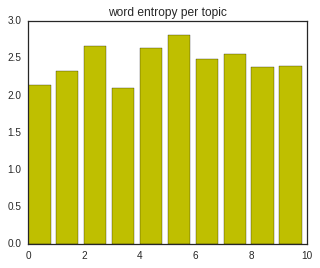

In [342]:
plt.rcParams['figure.figsize']=(5,4)
ax = plt.bar(range(len(topic_word_entropy)), topic_word_entropy, color='y')
plt.title('word entropy per topic')